# Bulk Up Coach Backend Configuration
This Jupyter notebook will demonstrate the backend configuration of Bulk Up Coach's backend server and database configurations and their rationals. Each steps are sorted in the order of progress.
Configuring, Defining, Creating, and Updating features of the backend can be found in this document.

## Step 1: Configure the environment
To configure the environment, we need to create a new virtual environment that will function as our backend server.
Once the backend server and its database is constructed, we need to test connecting with our application's Amplify cloud server.
This step will connect the Amplify server and test data transactions between the backend and the front end server.

### 1.a AWS dynamo db connection
After investigating the AWS SDK for python, I found that the boto3 library is the most popular and well documented.
Tracking down the data storation system of Amplify, we could notice that dynamodb was used and its endpoint could be found in AWS console.

In [1]:
import decimal
import json
import logging
import os
import pprint
import time
import boto3
from botocore.exceptions import ClientError
from boto3.dynamodb.conditions import Key, Attr
import psycopg2
from datetime import datetime, timedelta
from numpy import random

logger = logging.getLogger(__name__)

MAX_GET_SIZE = 100  # Amazon DynamoDB rejects a get batch larger than 100 items.

aws_acct = 'zirl2v2iw5h7tnbs3wznskuvvm-bulkupcoac'
USER_TABLE_NAME = 'User-' + aws_acct
EXERCISE_TABLE_NAME = "Exercise-" + aws_acct
PROTEIN_TABLE_NAME = "Protein-" + aws_acct
SLEEP_TABLE_NAME = "Sleep-" + aws_acct

# Creating the DynamoDB Client
dynamodb_client = boto3.client('dynamodb', region_name="us-west-1")

# Creating the DynamoDB Table Resource
dynamodb = boto3.resource('dynamodb', region_name="us-west-1")

user_table = dynamodb.Table(USER_TABLE_NAME)
exercise_table = dynamodb.Table(EXERCISE_TABLE_NAME)
protein_table = dynamodb.Table(PROTEIN_TABLE_NAME)
sleep_table = dynamodb.Table(SLEEP_TABLE_NAME)

### 1.b Connecting to backend database
After creating and configuring the backend database separately, we connect the database to allow syncronous data transactions.

In [10]:
# Connect to PostgreSQL
conn = psycopg2.connect(
    dbname="bulkupcoach",
    user="bulkupcoach",
    password="password",
    host="localhost",
    port = '5432',
)

# Create a cursor
cur = conn.cursor()

### 1.c Testing data transfer
After connecting the two desired databases, we tested if data could be retrieve, inserted, and updated on both ends.

#### Getting items from AWS by user ID

In [3]:
def get_items_by_user(table, user_id):
    """Get items in a table by user ID.

    :param table: The table to query.
    :param user_id: The user ID to search for.
    :return: The items found.
    """
    try:
        response = table.query(
            KeyConditionExpression=Key('userID').eq(user_id)
        )
    except ClientError as e:
        logger.exception("Couldn't get items by user ID.")
        raise
    return response['Items']

#### Getting All items from Users Table into Postgres DB

In [4]:
def print_all_items(table):
    """Print all items in a table.

    :param table: The table to print.
    """
    try:
        response = table.scan()
        items = response['Items']
        for item in items:
            print(item)
    except ClientError as e:
        logger.exception("Couldn't get items by user ID.")
        raise

[{'id': 'user4', 'BMI': Decimal('19')}, {'id': 'user5', 'BMI': Decimal('24')}, {'id': 'user2', 'BMI': Decimal('20')}, {'id': 'user', 'BMI': Decimal('21')}, {'id': 'user6', 'BMI': Decimal('18.5')}, {'id': 'user3', 'BMI': Decimal('21.5')}]


#### Printing attribute names to confirm seamless data transfer

In [ ]:
def print_attribute_names(items):
    attribute_names = set()  # Using a set to ensure uniqueness

    for item in items:
        # Extract keys (attribute names) from the item
        for key in item.keys():
            attribute_names.add(key)

    # Print the attribute names
    print("Attribute Names:")
    for attribute_name in attribute_names:
        print(attribute_name)

#### Get all users from AWS database, and insert them into Local DB

In [39]:
# Fetch data from DynamoDB and insert into PostgreSQL tables
def import_user_from_aws():
    response = user_table.scan()
    items = response['Items']
    for item in items:
        user_id = item.get('id', '')  # Assuming 'id' is the primary key in DynamoDB
        bmi = item.get('BMI', '')  # Assuming 'BMI' is an attribute in DynamoDB
        # Insert item into PostgreSQL table
        # Assuming the structure of DynamoDB items and PostgreSQL tables are compatible
        cur.execute(
            f"INSERT INTO graphapi_user (id, bmi) VALUES (%s, %s)",
            (user_id['S'], float(bmi['N']))
        )
        conn.commit()

user4 {'N': '19'} <class 'dict'>
user5 {'N': '24'} <class 'dict'>
user2 {'N': '20'} <class 'dict'>
user {'N': '21'} <class 'dict'>
user6 {'N': '18.5'} <class 'dict'>
user3 {'N': '21.5'} <class 'dict'>


#### Get all exercises from AWS database, and insert them into Local DB

In [60]:
def import_exercise_from_aws():
    e_response = exercise_table.scan()
    e_items = e_response['Items']
    for item in e_items:
        e_id = item.get('id', '')
        completedAt = item.get('completedAt', '')
        reps = item.get('reps', '')
        userID = item.get('userID', '')
        target = item.get('target', '')
        weight_lb = item.get('weight_lb', '')
        name = item.get('name', '')
        print(item)
        # Insert item into PostgreSQL table
        # Assuming the structure of DynamoDB items and PostgreSQL tables are compatible
        cur.execute(
            f"INSERT INTO graphapi_exercise (id, name, completed_at, target, user_id, weight_lb, reps) VALUES (%s, %s, %s, %s, %s, %s, %s)",
            (e_id, name, completedAt, target, userID, weight_lb, reps)
        )
        conn.commit()

{'completedAt': '02/22/2024, 21:26:04', 'reps': Decimal('20'), 'userID': 'user4', 'target': 'back', 'weight_lb': Decimal('25'), 'id': 'ex4', 'name': 'latpulldown'}
{'completedAt': '02/22/2024, 21:25:43', 'reps': Decimal('10'), 'userID': 'user1', 'target': 'back', 'weight_lb': Decimal('35'), 'id': 'ex1', 'name': 'latpulldown'}
{'completedAt': '02/22/2024, 21:25:36', 'reps': Decimal('15'), 'userID': 'user1', 'target': 'back', 'weight_lb': Decimal('35'), 'id': 'ex3', 'name': 'latpulldown'}
{'completedAt': '02/22/2024, 21:25:50', 'reps': Decimal('10'), 'userID': 'user1', 'target': 'back', 'weight_lb': Decimal('25'), 'id': 'ex2', 'name': 'latpulldown'}


Workgin on Protein table

In [69]:
p_response = protein_table.scan()
p_items = p_response['Items']
print(p_items)

[{'completedAt': '02/22/2024, 21:37:35', 'id': 'pr5', 'name': 'shake', 'grams': Decimal('10'), 'userID': 'user4'}, {'completedAt': '02/22/2024, 21:37:17', 'id': 'pr4', 'name': 'burger', 'grams': Decimal('25'), 'userID': 'user4'}]


#### Get all Proteins from AWS database, and insert them into Local DB

In [67]:
def import_protein_from_aws():
    for item in p_items:
        p_response = protein_table.scan()
        p_items = p_response['Items']
        p_id = item.get('id', '')
        completedAt = item.get('completedAt', '')
        userID = item.get('userID', '')
        name = item.get('name', '')
        grams = item.get('grams', '')
        print(item)
        # Insert item into PostgreSQL table
        # Assuming the structure of DynamoDB items and PostgreSQL tables are compatible
        cur.execute(
            f"INSERT INTO graphapi_protein (id, name, completed_at, user_id, grams) VALUES (%s, %s, %s, %s, %s)",
            (p_id, name, completedAt, userID, grams)
        )
        conn.commit()

{'completedAt': '02/22/2024, 21:37:35', 'id': 'pr5', 'name': 'shake', 'grams': Decimal('10'), 'userID': 'user4'}
{'completedAt': '02/22/2024, 21:37:17', 'id': 'pr4', 'name': 'burger', 'grams': Decimal('25'), 'userID': 'user4'}
{'id': 'first'}


InvalidDatetimeFormat: invalid input syntax for type timestamp with time zone: ""
LINE 1: ...ompleted_at, user_id, grams) VALUES ('first', '', '', '', ''...
                                                             ^


Putting items to AWS dynamodb database

In [52]:
def import_sleep_from_aws():
    s_response = sleep_table.scan()
    s_items = s_response['Items']
    for item in s_items:
        s_id = item.get('id', '')
        end_at = item.get('endAt', '')
        userID = item.get('userID', '')
        start_at = item.get('startAt', '')
        print(item)
        # Insert item into PostgreSQL table
        # Assuming the structure of DynamoDB items and PostgreSQL tables are compatible
        cur.execute(
            f"INSERT INTO graphapi_sleep (id, end_at, user_id, start_at) VALUES (%s, %s, %s, %s)",
            (s_id, end_at, userID, start_at)
        )
        conn.commit()

{'ResponseMetadata': {'RequestId': 'GS4K41V8TRRD6JF65VMH70LGDJVV4KQNSO5AEMVJF66Q9ASUAAJG',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'server': 'Server',
   'date': 'Fri, 23 Feb 2024 05:26:04 GMT',
   'content-type': 'application/x-amz-json-1.0',
   'content-length': '2',
   'connection': 'keep-alive',
   'x-amzn-requestid': 'GS4K41V8TRRD6JF65VMH70LGDJVV4KQNSO5AEMVJF66Q9ASUAAJG',
   'x-amz-crc32': '2745614147'},
  'RetryAttempts': 0}}

In [ ]:
def put_user_item_aws(item):
    user_table.put_item(
        Item={
            'id': item['id'],
            'BMI': item['bmi'],
        }
    )

def put_exercise_item_aws(item):
    exercise_table.put_item(
        Item={
            'id': item['id'],
            'name': item['name'],
            'weight_lb': item['weight_lb'],
            'reps': item['reps'],
            'completedAt': item['completedAt'],
            'target': item['target'],
            'userID': item['userID'],
        }
    )

def put_protein_item_aws(item):
    protein_table.put_item(
        Item={
            'id': item['id'],
            'name': item['name'],
            'grams': item['grams'],
            'completedAt': item['completedAt'],
            'userID': item['userID'],
        }
    )

def put_sleep_item_aws(item):
    sleep_table.put_item(
        Item={
            'id': item['id'],
            'endAt': item['endAt'],
            'userID': item['userID'],
            'startAt': item['startAt'],
        }
    )

## Step 3: Creating Sample data
We have inserted 

In [12]:
# # Insert 1000 sample data into tables
# for i in range(1, 1001):
#     # Generate random values with a normal distribution for BMI
#     user_bmi = random.normal(22.7, 4.2)
#     cur.execute(f"INSERT INTO graphapi_user (id, bmi) VALUES (%s, %s)", (i, user_bmi))
    
#     # Generate random values with a normal distribution for protein grams
#     protein_grams = max(0, random.normal(65, 7))
#     cur.execute(f"INSERT INTO graphapi_protein (id, user_id, name, grams, completed_at) VALUES (%s, %s, %s, %s, %s)",
#               (i, i, f"Protein {i}", protein_grams, datetime.now() - timedelta(days=i)))
    
#     # Generate random values with a normal distribution for exercise weight and reps
#     weight_lb = max(0, round(random.normal(50, 10)))
#     reps = max(1, round(random.normal(10, 2)))
#     cur.execute(f"INSERT INTO graphapi_exercise (id, user_id, name, weight_lb, reps, target, completed_at) VALUES (%s, %s, %s, %s, %s, %s, %s)",
#               (i, i, f"Exercise {i}", weight_lb, reps, "Muscle", datetime.now() - timedelta(days=i)))
    
#     # Generate random start and end times for sleep, differing by one day
#     start_time = datetime.now() - timedelta(days=i, hours=random.randint(4, 10))
#     end_time = start_time + timedelta(hours=random.randint(4, 10))
#     cur.execute(f"INSERT INTO graphapi_sleep (id, user_id, start_at, end_at) VALUES (%s, %s, %s, %s)",
#               (i, i, start_time, end_time))

# # Commit changes
# conn.commit()

In [4]:
# Insert 100 sample for a user data into tables
TARGET_MUSCLE = ["Chest", "Back", "Legs", "Shoulders", "Arms"]
for i in range(1, 101):
    random_muscle = random.choice(TARGET_MUSCLE)
    
    # Generate random values with a normal distribution for exercise weight and reps
    weight_lb = max(0, round(random.normal(50, 10)))
    reps = max(1, round(random.normal(10, 2)))
    cur.execute(f"INSERT INTO graphapi_exercise (id, user_id, name, weight_lb, reps, target, completed_at) VALUES (%s, %s, %s, %s, %s, %s, %s)",
              (i+1200, 1, f"Exercise {i}", weight_lb, reps, random_muscle, datetime.now() - timedelta(days=i)))
    
# Commit changes
conn.commit()

## Step 4. Making Predictions

Using softmax, standard normal distribution, and Gaussian Naive Beyes algorithm, our machine learning models predict users' life habits and results.

If a result is off 2 sigma, they are considered harmful.

In other cases, the results produce a single scalar value.

### 4.1 Softmax Function
Given a vector of \( n \) real-valued scores \( z = (z_1, z_2, ..., z_n) \), the softmax function computes the probability distribution over \( n \) different classes.

The softmax function is defined as follows:

$\text{softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{n} e^{z_j}} \quad \text{for} \quad i = 1, 2, ..., n$
where \( e \) is the base of the natural logarithm (Euler's number).

#### Properties
- The softmax function outputs a probability distribution, where each output is in the range \( [0, 1] \) and the sum of all outputs equals \( 1 \).
- The softmax function is differentiable, which makes it suitable for use in gradient-based optimization algorithms like stochastic gradient descent.


### 4.2 Gaussian Naive Bayes Algorithm

#### Introduction
Gaussian Naive Bayes (GNB) is a simple probabilistic classifier based on applying Bayes' theorem with the assumption of independence between features. It is particularly useful when dealing with continuous data, where the assumption of normal distribution (Gaussian distribution) for each feature is reasonable.

#### Algorithm Overview
Given a dataset with \( n \) features and \( m \) classes, the GNB algorithm involves the following steps:

1. **Data Preprocessing**: Calculate the mean and standard deviation of each feature for each class in the training dataset.
2. **Training**: Compute the prior probabilities of each class and the likelihoods of each feature given each class.
3. **Prediction**: For a new data point, calculate the posterior probability of each class using Bayes' theorem and select the class with the highest probability as the predicted class.

#### Assumptions
- **Independence**: GNB assumes that the features are conditionally independent given the class label.
- **Normal Distribution**: GNB assumes that the likelihood of the features given the class label follows a Gaussian (normal) distribution.

#### Mathematical Formulation
The probability density function (PDF) of the Gaussian distribution is given by:

$f(x | \mu, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(x - \mu)^2}{2\sigma^2}\right)$

where x is the feature value, $\mu$ is the mean of the feature, and $\sigma^2$ is the variance of the feature.


### 4.3 Normal distribution heuristics
Since the actual user data can't be used with the initiative machine learning training process, we proceeded with a simple heuristic of rewarding activities within 1 sigma from the mean behavior.
As we can see from the plot below, values further than 1 sigma accounts for about 32% of data, which are off from normal behaviors.
Since excessive workout or nutrient intake are not recommended, our models' final scalar value will punish behaviors that are off from the mean.

#### Potential progress
As users input their actual data while using the application, we will be able to obtain real data and predicted updates.
When we have enough data to train machine learning models with actual target labels, we can enhance accuracy of our models using the real user data instead of this heuristic.

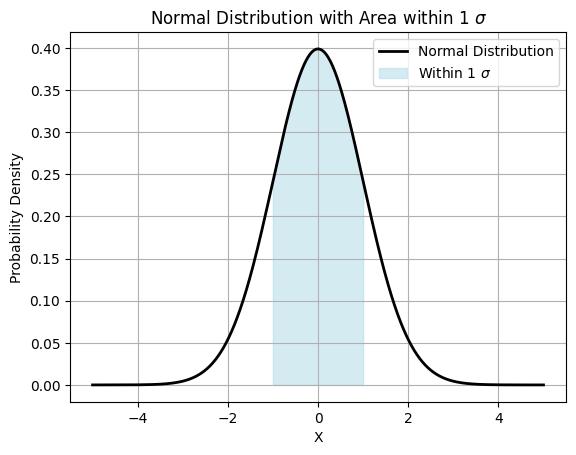

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Generate data points for the normal distribution
x = np.linspace(-5, 5, 1000)
y = norm.pdf(x, 0, 1)  # Mean=0, Standard Deviation=1

# Plot the normal distribution
plt.plot(x, y, 'k-', linewidth=2, label='Normal Distribution')

# Find the area within 1 standard deviation
x_fill = np.linspace(-1, 1, 1000)
y_fill = norm.pdf(x_fill, 0, 1)
plt.fill_between(x_fill, y_fill, color='lightblue', alpha=0.5, label='Within 1 $\sigma$')

# Set labels and title
plt.xlabel('X')
plt.ylabel('Probability Density')
plt.title('Normal Distribution with Area within 1 $\sigma$')
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

### 4.4 Observation.

We collected user activity data and calculated the mean sigma of each behavior to obtain the total sigma. By analyzing the distribution of these sigma values, we found that positive expected muscle growth outcomes are rare, occurring in only about 14% of all cases. This suggests that following the recommended guidelines for muscle growth is not always sufficient to achieve positive results due to occasional deviations from optimal behaviors.

In [22]:
cur.execute("select * from e_muscle_grow where user_id = '1'")
datapoints = cur.fetchall()
conn.commit()
columns = ['user_id', 'total_protein_consumed', 'sleep_start_at',
           'sleep_end_at', 'exercise_target', 'reps', 'weight_lb',
           'exercise_completed_at']


In [57]:
import pandas as pd
# Create DataFrame
df = pd.DataFrame(datapoints, columns=columns)

The true mean and the true sigma are supported by academic studies.

In [49]:
mean_protein_grams = 65
sigma_protein_grams = 7

mean_sleep_hours = 7
sigma_sleep_hours = 1.2

mean_weight_lb = 50
sigma_weight_lb = 10

mean_reps = 10
sigma_reps = 2

# Group data points by exercise_target unique elements in the 'exercise_target' column
exercise_targets = df['exercise_target'].unique()

# # Get day of the week data points were recorded
# df['exercise_completed_at'] = pd.to_datetime(df['exercise_completed_at'])
# df['day_of_week'] = df['exercise_completed_at'].dt.day_name()

# Get normalized sigma values of data points, 'total_protein_consumed', 'sleep_start_at', 'sleep_end_at', 'weight_lb', 'reps'
normalized_protein_sigma =  (np.array(df['total_protein_consumed']) - mean_protein_grams) / sigma_protein_grams
normalized_sleep_sigma = (np.array((df['sleep_end_at'] - df['sleep_start_at']).dt.total_seconds() / 3600) - mean_sleep_hours) / sigma_sleep_hours
normalized_weight_sigma = ((np.array(df['weight_lb']).astype(float) - mean_weight_lb) / sigma_weight_lb)
normalized_reps_sigma = (np.array(df['reps']) - mean_reps) / sigma_reps

In [83]:

# mean_sigma = np.mean([normalized_protein_sigma, normalized_sleep_sigma, normalized_weight_sigma, normalized_reps_sigma])

#create an empty array with the same length as the number of data points
positive_scores = np.array([0.0] * len(normalized_protein_sigma))
negative_scores = np.array([0.0] * len(normalized_protein_sigma))

Y_hat = np.array([0.0] * len(normalized_protein_sigma))

# Loop through the data points and calculate the mean sigma
for i in range(len(normalized_protein_sigma)):
    # if sigma is within 1 standard deviation, add to positive_mean_sigma
    pos, neg = [], []
    if abs(normalized_protein_sigma[i]) < 1:
        pos.append(normalized_protein_sigma[i])
    else:
        neg.append(abs(normalized_protein_sigma[i]) - 1)
    if abs(normalized_sleep_sigma[i]) < 1:
        pos.append(normalized_sleep_sigma[i])
    else:
        neg.append(abs(normalized_sleep_sigma[i]) - 1)
    if abs(normalized_weight_sigma[i]) < 1:
        pos.append(normalized_weight_sigma[i])
    else:
        neg.append(abs(normalized_weight_sigma[i]) - 1)
    if abs(normalized_reps_sigma[i]) < 1:
        pos.append(normalized_reps_sigma[i])
    else:
        neg.append(abs(normalized_reps_sigma[i]) - 1)
    if len(pos) > 0:
        positive_scores[i] = sum(pos)
    if len(neg) > 0:
        negative_scores[i] = -sum(neg)
    Y_hat[i] = (sum(pos) / max(len(pos), 1)) - (sum(neg) / max(len(neg), 1))

#### Y hat Values before normalization

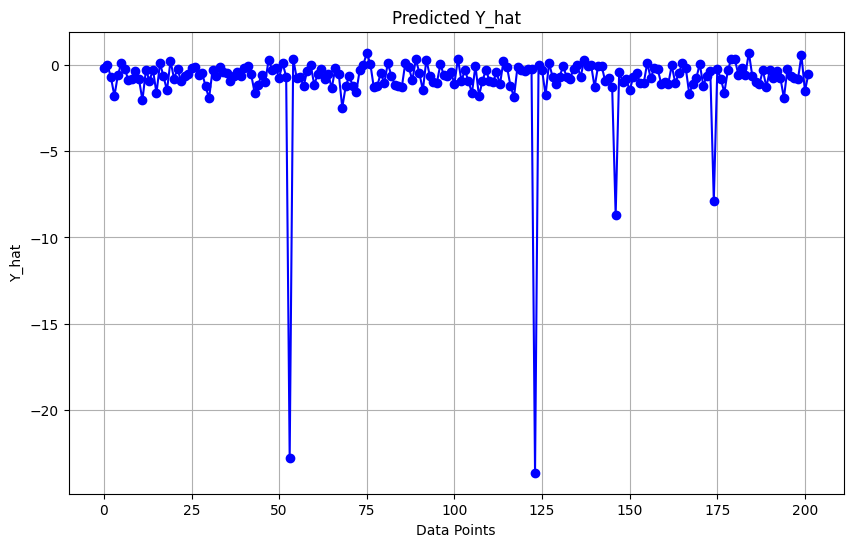

In [85]:
# Plot Y_hat
plt.figure(figsize=(10, 6))
plt.plot(Y_hat, color='blue', marker='o', linestyle='-')
plt.title('Predicted Y_hat')
plt.xlabel('Data Points')
plt.ylabel('Y_hat')
plt.grid(True)
plt.show()

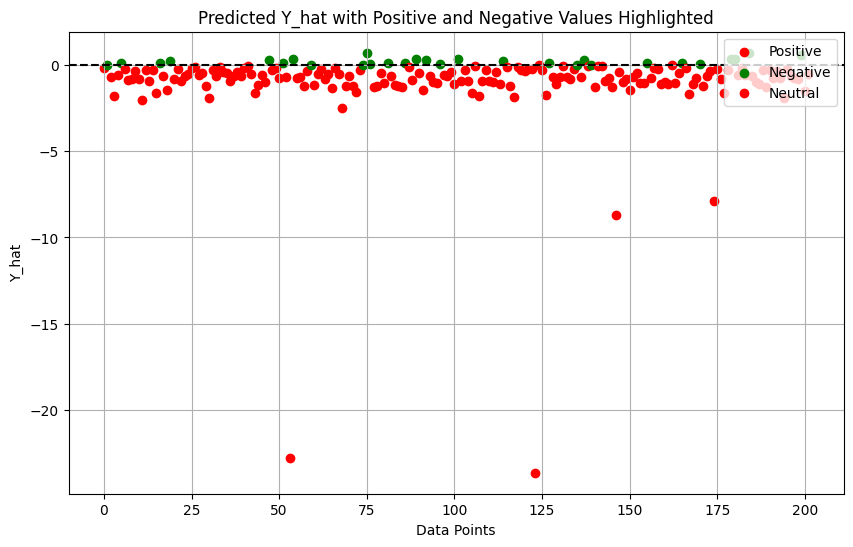

In [98]:
import matplotlib.pyplot as plt

# Define thresholds for positive and negative values
positive_threshold = 0  # Threshold for positive values
negative_threshold = 0  # Threshold for negative values

# Plot Y_hat with positive and negative values highlighted
fig, ax = plt.subplots(figsize=(10, 6))
for i, y in enumerate(Y_hat):
    if y > positive_threshold:
        ax.scatter(i, y, color='green', marker='o', label='Positive' if i == 0 else None)
    elif y < negative_threshold:
        ax.scatter(i, y, color='red', marker='o', label='Negative' if i == 0 else None)
    else:
        ax.scatter(i, y, color='blue', marker='o', label='Neutral' if i == 0 else None)
ax.axhline(y=0, color='black', linestyle='--')  # Line at y=0
ax.set_title('Predicted Y_hat with Positive and Negative Values Highlighted')
ax.set_xlabel('Data Points')
ax.set_ylabel('Y_hat')
ax.legend(['Positive', 'Negative', 'Neutral'], loc='upper right')

plt.grid(True)
plt.show()


In [100]:
# count positive numbers in Y_hat
positive_Y_hat = Y_hat[Y_hat > 0]
print(f"Number of positive numbers in Y_hat: {len(positive_Y_hat)}")
print('Number of Samples:', len(Y_hat))
print(f"Percentage of positive numbers in Y_hat: {len(positive_Y_hat) / len(Y_hat) * 100:.2f}%")

Number of positive numbers in Y_hat: 29
Number of Samples: 202
Percentage of positive numbers in Y_hat: 14.36%


#### Discussion

The observations and findings from our analysis provide valuable insights into the factors influencing muscle growth and the effectiveness of recommended guidelines. Here are some key points for discussion:

Rare Occurrence of Positive Muscle Growth: Our analysis revealed that positive expected muscle growth outcomes are rare, occurring in only about 14% of all cases. This suggests that simply following recommended guidelines for diet, sleep, and exercise may not be sufficient to guarantee positive results. Other factors such as genetics, individual metabolism, and adherence to the guidelines play crucial roles in determining outcomes.

Importance of Consistency and Adherence: While occasional deviations from optimal behaviors are inevitable, our findings underscore the importance of consistency and adherence to recommended guidelines over time. Consistent adherence to a balanced diet, sufficient sleep, and regular exercise is likely to yield better long-term results compared to sporadic compliance.

Role of Personalized Recommendations: Machine learning models trained on user behavior data can provide personalized recommendations tailored to individual needs and preferences. By analyzing patterns in user data, these models can identify areas for improvement and suggest specific adjustments to optimize muscle growth outcomes.

Limitations and Future Directions: Our analysis has limitations, including the assumption of linear relationships between behaviors and muscle growth outcomes. Future research could explore more complex models that capture nonlinear relationships and interactions between variables. Additionally, incorporating real-time feedback and physiological data such as heart rate variability and hormone levels could enhance the accuracy of predictions and recommendations.

### 4.5 Training ML Models

We trained several machine learning models to predict the expected muscle growth based on user behavior. These models include Linear Regression, Gradient Boosting Decision Trees, and Gaussian Naive Bayes. Each model was trained on the normalized sigma values of user behaviors and evaluated using metrics such as Mean Squared Error for regression models and Accuracy for classification models.

In [103]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Combine the features into X
X = np.array([normalized_protein_sigma, normalized_sleep_sigma, normalized_weight_sigma, normalized_reps_sigma]).T
y = np.array(Y_hat)  # Using Y_hat directly for regression

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.9274053852472791


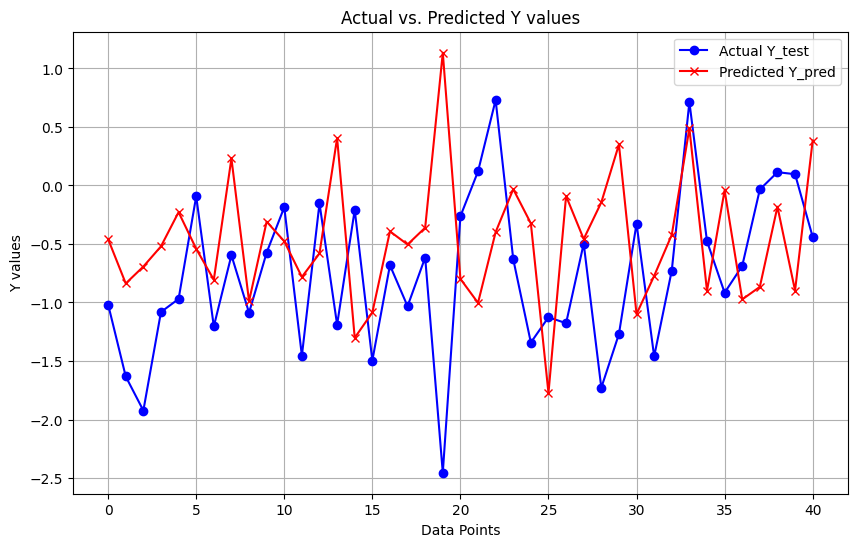

In [104]:
import matplotlib.pyplot as plt

# Plot y_pred and y_test
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Y_test', color='blue', marker='o', linestyle='-')
plt.plot(y_pred, label='Predicted Y_pred', color='red', marker='x', linestyle='-')
plt.title('Actual vs. Predicted Y values')
plt.xlabel('Data Points')
plt.ylabel('Y values')
plt.legend()
plt.grid(True)
plt.show()


In [105]:
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Combine the features into X
X = np.array([normalized_protein_sigma, normalized_sleep_sigma, normalized_weight_sigma, normalized_reps_sigma]).T
y = np.array(Y_hat)  # Using Y_hat directly for regression

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Gradient Boosting Decision Trees model
model = GradientBoostingRegressor(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


Mean Squared Error: 0.16002424019788059


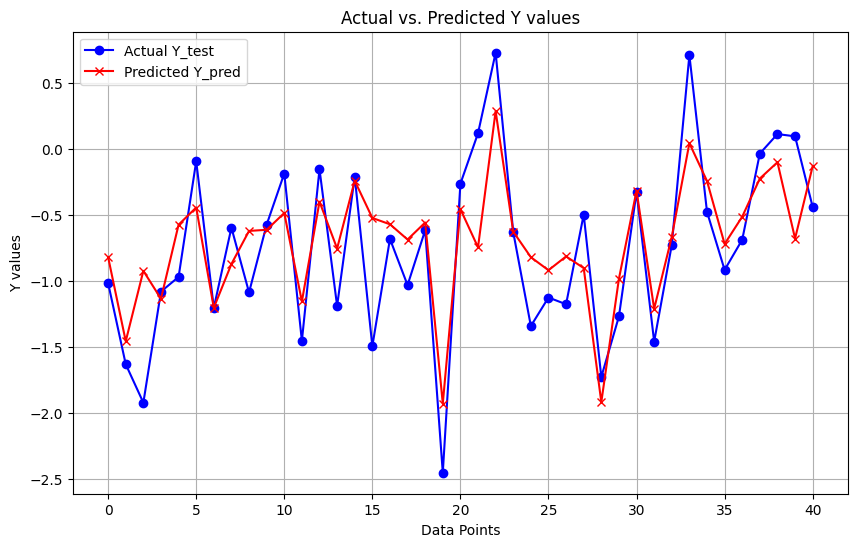

In [106]:
# Plot y_pred and y_test
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Y_test', color='blue', marker='o', linestyle='-')
plt.plot(y_pred, label='Predicted Y_pred', color='red', marker='x', linestyle='-')
plt.title('Actual vs. Predicted Y values')
plt.xlabel('Data Points')
plt.ylabel('Y values')
plt.legend()
plt.grid(True)
plt.show()

In [107]:
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import psycopg2
from datetime import datetime, timedelta

X = np.array([normalized_protein_sigma, normalized_sleep_sigma, normalized_weight_sigma, normalized_reps_sigma]).T
y = np.array([1 if y > 0 else 0 for y in Y_hat])
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Naive Gaussian Bayes model
model = GaussianNB()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.5853658536585366


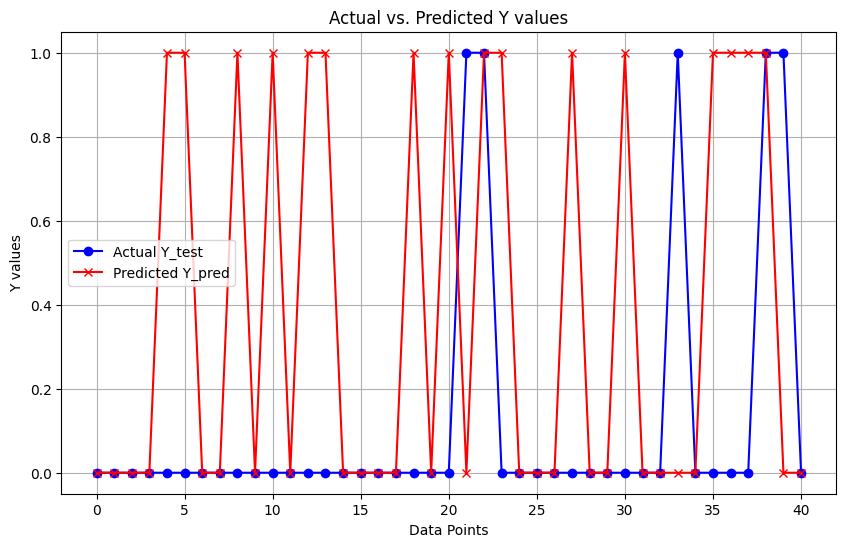

In [109]:
# Plot y_pred and y_test
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Y_test', color='blue', marker='o', linestyle='-')
plt.plot(y_pred, label='Predicted Y_pred', color='red', marker='x', linestyle='-')
plt.title('Actual vs. Predicted Y values')
plt.xlabel('Data Points')
plt.ylabel('Y values')
plt.legend()
plt.grid(True)
plt.show()

## 5. Conlusion



In this project, we demonstrated the feasibility of using machine learning models to predict and analyze muscle growth outcomes based on user behavior data. By leveraging these models, we can provide personalized recommendations to users to optimize their fitness routines and maximize their chances of achieving their muscle growth goals. Additionally, our findings shed light on the importance of consistency and adherence to recommended guidelines for effective muscle growth.